In [209]:
from pathlib import Path
import os
from BNS_JT import variable, cpm
import config_pm, batch
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import networkx as nx
from matplotlib.lines import Line2D
import pickle
import time
from scipy.stats import multivariate_normal

HOME = Path(os.getcwd())
output_path = HOME / "output"

cfg = config_pm.Config_pm(HOME / "input/config.json")
node_coords = {}
for k, v in cfg.infra['nodes'].items():
    node_coords[k] = (v['pos_x'], v['pos_y'])

arcs = {}
for k, v in cfg.infra['edges'].items():
    arcs[k] = [v['origin'], v['destination']]

epi_loc = cfg.infra['eq']['s1']['epicentre']
os_list = cfg.infra['origins']

# Mapping results

Load results

In [2]:
node_pfs = {}
with open(output_path / "result.txt") as f:
    for line in f:
        node, pf, nsamp = line.strip().split("\t")
        node_pfs[node] = float(pf)

print(node_pfs)

{'n63': 0.26757, 'n53': 0.00081841, 'n44': 6.9113e-05, 'n35': 0.0029762, 'n13': 0.0015887, 'n8': 1.7042e-10, 'n4': 5.2637e-06, 'n10': 1.9248e-08, 'n67': 0.019366, 'n39': 0.0082088, 'n30': 0.0012633, 'n48': 6.4212e-06, 'n17': 3.8081e-08, 'n62': 0.3918, 'n57': 0.018534, 'n71': 0.010233, 'n34': 0.0021774, 'n20': 0.00076318, 'n43': 5.4075e-05, 'n52': 3.6391e-05, 'n21': 0.00019239, 'n15': 0.0020479, 'n38': 0.0098154, 'n18': 0.000126, 'n47': 4.9918e-05, 'n12': 0.0017064, 'n56': 0.1816, 'n26': 0.0011094, 'n14': 8.5794e-06, 'n70': 0.34886, 'n33': 4.5435e-05, 'n11': 7.8455e-09, 'n9': 0.0015962, 'n42': 0.012824, 'n6': 7.9404e-11, 'n1': 2.1795e-08, 'n51': 3.619e-06, 'n16': 1.066e-07, 'n74': 0.0014777, 'n60': 0.0011375, 'n28': 0.0024724, 'n72': 0.094308, 'n65': 0.13324, 'n37': 0.0095771, 'n29': 0.0033276, 'n46': 5.5018e-05, 'n24': 0.001056, 'n2': 0.001856, 'n55': 0.082564, 'n69': 0.021127, 'n61': 0.11465, 'n32': 0.0014056, 'n7': 9.7959e-08, 'n41': 0.00016755, 'n50': 8.1016e-07, 'n59': 0.011479, 'n

Re-evaluation to consider dependency

In [204]:
pf, MEAN, VAR, COV, Rrup, ln_Sa, std_al, std_ep, frag_mean_beta = batch.cal_edge_dist(cfg.infra, 's1')
print(MEAN)
print(VAR)
print(COV)
print(ln_Sa)
print(std_al)
print(std_ep)

{'e1': 2.39488503597786, 'e2': 2.3998888022436597, 'e3': 2.3960172524838117, 'e4': 2.3709540607033586, 'e5': 2.3302129791536816, 'e6': 2.39488503597786, 'e7': 2.3302129791536816, 'e8': 2.3025382244497474, 'e9': 2.213573344225619, 'e10': 2.2311992336645594, 'e11': 2.389549601439377, 'e12': 2.3302129791536816, 'e13': 2.2696534777736197, 'e14': 2.3960172524838117, 'e15': 2.3456808669339373, 'e16': 2.2350992595623698, 'e17': 2.2572112752054476, 'e18': 2.3913068097256036, 'e19': 2.3456808669339373, 'e20': 2.3005847212152486, 'e21': 2.2017982590918694, 'e22': 2.0540340806596316, 'e23': 2.2201767908092798, 'e24': 2.410232649745998, 'e25': 2.3456808669339373, 'e26': 2.2696534777736197, 'e27': 2.231084240696576, 'e28': 2.3442226521950773, 'e29': 2.2201767908092798, 'e30': 2.231084240696576, 'e31': 2.231084240696576, 'e32': 2.288809636081499, 'e33': 2.1485711779379963, 'e34': 2.2201767908092798, 'e35': 2.0540340806596316, 'e36': 1.8648746767326412, 'e37': 1.9225433586853884, 'e38': 2.14857117793

In [225]:
pfs_1d = {}
pfs_bnd_1d = {}
cov_1d = {}
times_1d = {}

for node in node_coords:
    if node != 'epi' and node not in os_list:
        start_ = time.time()

        with open( output_path / f"cpms_{node}.pk", 'rb') as f:
            cpms = pickle.load(f)

        cpm_node = cpms[node]

        p_node = np.zeros_like(cpm_node.p)

        for j, c in enumerate(cpm_node.C):

            mean_ = np.zeros((0,1), dtype=float)
            cov_ = np.zeros((0,0), dtype=float)
            arcs_idx_ = []

            for j2, (k,v) in enumerate(arcs.items()):
                c_idx = next((i for i,x in enumerate(cpm_node.variables) if x.name==k), None)

                if c[c_idx] != 2: # no composite state

                    if c[c_idx] == 1: # survival
                        mean_ = np.vstack((mean_, -MEAN[k] + ln_Sa[k]))
                    elif c[c_idx] == 0: # failure
                        mean_ = np.vstack((mean_, MEAN[k] - ln_Sa[k]))

                    cov1_ = np.zeros((len(arcs_idx_), 1), dtype=float)
                    for i,c_idx2 in enumerate(arcs_idx_):
                        cov1_[i] = COV[c_idx2, j2]
                    cov_ = np.hstack( (cov_, cov1_) )
                    cov1_ = np.vstack( (cov1_, COV[j2, j2]) )
                    cov_ = np.vstack( (cov_, cov1_.T ) )

                    arcs_idx_.append(j2)

            mean_ = np.squeeze(mean_)
            p_ = multivariate_normal.cdf(np.zeros((len(arcs_idx_),), dtype=float), mean_, cov_)
            p_node[j] = p_

        p_node = p_node / sum(p_node) # normalisation due to numerical errors from mvn cdf
        if len(cpm_node.Cs) == 0:

            cpm_node.p = p_node
            pf_low = cpm.get_prob(cpm_node, [node], [0])  
            pf_unk = cpm.get_prob(cpm_node, [node], [2] )
            pfs_1d[node] = pf_low   
            pfs_bnd_1d[node] = pf_unk
            cov_1d[node] = 0.0

        else:
            ps_ = np.zeros_like(cpm_node.q, dtype=float)

            for i in range(len(cpm_node.q)):
                
                cs_ = cpm_node.Cs[i]
                mean_ = np.zeros((0,1), dtype=float)
                cov_ = np.zeros((0,0), dtype=float)
                arcs_idx_ = []

                for j2, (k,v) in enumerate(arcs.items()):
                    c_idx = next((i for i,x in enumerate(cpm_node.variables) if x.name==k), None)

                    if cs_[c_idx] == 1: # survival
                        mean_ = np.vstack((mean_, -MEAN[k] + ln_Sa[k]))
                    elif cs_[c_idx] == 0: # failure
                        mean_ = np.vstack((mean_, MEAN[k] - ln_Sa[k]))

                    cov1_ = np.zeros((len(arcs_idx_), 1), dtype=float)
                    for i2,c_idx2 in enumerate(arcs_idx_):
                        cov1_[i2] = COV[c_idx2, j2]
                    cov_ = np.hstack( (cov_, cov1_) )
                    cov1_ = np.vstack( (cov1_, COV[j2, j2]) )
                    cov_ = np.vstack( (cov_, cov1_.T ) )

                    arcs_idx_.append(j2)

                mean_ = np.squeeze(mean_)
                p_ = multivariate_normal.pdf(np.zeros((len(arcs),), dtype=float), mean_, cov_)
                ps_[i] = p_

            cpms[k].ps = ps_
            cpm_node.p = p_node

            m_unk = cpm.Cpm( [cpm_node.variables[0]], 1, np.array([2]), np.array([1.0]) ) # remove unknown state instances
            is_cmp = cpm_node.iscompatible( m_unk )
            cpm_node = cpm_node.get_subset( [i for i, v in enumerate(is_cmp) if not v] )

            prob, cov, cint_95 = cpm.get_prob_and_cov( cpm_node, [node], [0], method='Bayesian' )

            pf_low = cpm.get_prob(cpm_node, [node], [0])  
            pf_unk = cpm.get_prob(cpm_node, [node], [2] )
            pfs_1d[node] = cint_95[0]   
            pfs_bnd_1d[node] = cint_95[1] - cint_95[0]  
            cov_1d[node] = cov

        end_ = time.time()
        times_1d[node] = end_ - start_

        print(f"{node} done.")
        print(f"Time (minutes) taken for probability evaluation with dependency considered: {(end_-start_)/60.0:.2f}")
        print(pfs_1d[node], pfs_bnd_1d[node])


n1 done.
Time (minutes) taken for probability evaluation with dependency considered: 1.37
7.137258770175551e-14 2.2446172056431025e-13
n2 done.
Time (minutes) taken for probability evaluation with dependency considered: 0.22
6.3342715045333356e-09 1.0096138940707085e-11
n3 done.
Time (minutes) taken for probability evaluation with dependency considered: 2.44
9.355636479971244e-14 1.784413982378451e-13
n4 done.
Time (minutes) taken for probability evaluation with dependency considered: 0.19
5.366064112131136e-12 1.0306682500809467e-12
n5 done.
Time (minutes) taken for probability evaluation with dependency considered: 0.12
3.335491797428701e-11 3.984841241329178e-12
n6 done.
Time (minutes) taken for probability evaluation with dependency considered: 0.69
2.493290345229226e-14 5.0016137060768725e-14
n7 done.
Time (minutes) taken for probability evaluation with dependency considered: 0.13
5.176285150842647e-13 1.317732550608706e-13
n8 done.
Time (minutes) taken for probability evaluation 

Interpolate between nodes for visualisation

In [157]:
def draw_pf_map(node_coords, node_pfs, arcs, epi_loc, os_list, Mw, fig_name, is_legend, is_cmap, margin):

    coords_list = []
    pfs_list = []
    for k, v in node_coords.items():
        if k in node_pfs:
            coords_list.append(v)
            pfs_list.append(node_pfs[k])

    x_coords = [coord[0] for coord in coords_list]
    y_coords = [coord[1] for coord in coords_list]

    plt.figure()
    grid_x, grid_y = np.mgrid[min(x_coords):max(x_coords):100j, min(y_coords):max(y_coords):100j]
    grid_z = griddata(coords_list, pfs_list, (grid_x, grid_y), method='linear')

    # Create a color map using imshow
    im = plt.imshow(grid_z.T, norm=colors.LogNorm(vmin = 1.0e-12, vmax = 1.0), extent=(min(x_coords), max(x_coords), min(y_coords), max(y_coords)),
            origin='lower', cmap='inferno')

    f_size = 15    
    if is_cmap:
        cbar = plt.colorbar(im, shrink=0.8) 
        font_style = {'size': f_size, 'family': 'Times New Roman'}
        cbar.set_label('Failure probability', fontdict = font_style)
        tick_labels = cbar.ax.get_yticklabels()
        cbar.ax.set_yticklabels(tick_labels, fontdict=font_style)

    # Graph
    G = nx.Graph()
    for k, v in node_coords.items():
        G.add_node(k, pos=v)
    for k,v in arcs.items():
        G.add_edge(v[0], v[1])
    G.add_node('epi', pos=epi_loc)
    node_coords['epi'] = epi_loc

    # Draw the graph
    nx.draw(G, node_coords, nodelist = [n for n in node_coords if n != 'epi'], node_color='k', edge_color='w', node_size=5)

    ## Origin nodes
    nx.draw_networkx_nodes(G, node_coords, nodelist=os_list, node_color='b', node_size=100, node_shape='*' )
    ## Epicentre
    nx.draw_networkx_nodes(G, node_coords, nodelist = ['epi'], node_color='r', node_size=50, node_shape='x')

    ## Legend
    if is_legend:
        legend_elements = [Line2D([0], [0], marker='o', color='w', label='Node',
                                markerfacecolor='k', markersize=5),
                        Line2D([0], [0], marker='*', color='w', label='Origin',
                                markerfacecolor='b', markersize=10),
                        Line2D([0], [0], marker='x', color='w', label='Epicentre',
                                markeredgecolor='r', markersize=6)]
        font_style_l = {'size': f_size, 'family': 'Times New Roman'}
        plt.legend(handles=legend_elements, loc=[-0.15,0.8], prop=font_style_l, handletextpad=0.00001)

    plt.subplots_adjust(left=margin[0], right=margin[1], top=margin[2], bottom=margin[3])
    plt.savefig(fig_name, dpi=500)

    # Show the plot
    %matplotlib inline
    plt.show()

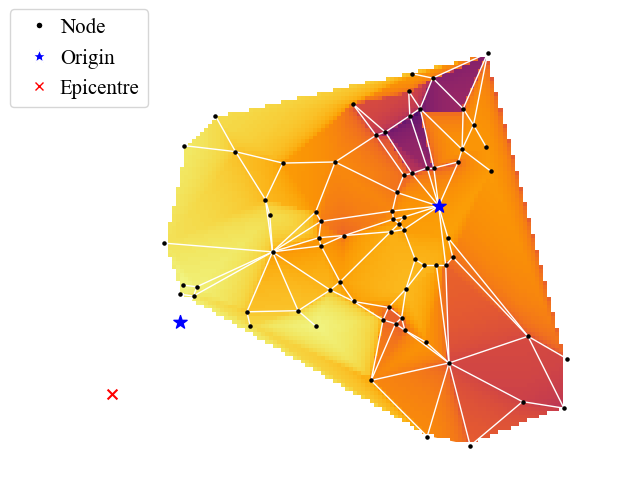

In [158]:
draw_pf_map(node_coords, node_pfs, arcs, epi_loc, os_list, cfg.infra['eq']['s1']['Mw'], 'pf_map1.png', is_legend=True, is_cmap=False, margin=[-0.2, 1.3, 0.99, 0.0])

# Update the probability

With another scenario 's2' (could be a new hazard scenario or an observed one).

In [5]:
eq_name = 's2'

epi_loc2 = cfg.infra['eq'][eq_name]['epicentre']
pf, MEAN, VAR, COV, Rrup, ln_Sa, std_al, std_ep, frag_mean_beta = batch.cal_edge_dist(cfg.infra, eq_name)
probs = {k: {0:v, 1:1-v} for k,v in pf.items()}

with open(output_path / "varis.pk", 'rb') as f:
    varis = pickle.load(f)


In [20]:
node_pfs2 = {}
node_covs2 = {}
start = time.time()
for node in node_coords:
    if node != 'epi' and node not in os_list:
        with open( output_path / f"cpms_{node}.pk", 'rb') as f:
            cpms = pickle.load(f)

        for k, v in arcs.items():
            cpms[k].p = np.array([probs[k][0], probs[k][1]], dtype=float).T

        if len(cpms[node].Cs) > 0:

            ps = np.zeros_like(cpms[k].q, dtype=float)
            for i in range(len(cpms[k].q)):
                ps[i] = cpm.get_prob(cpms[k], [k], cpms[k].Cs[i])
            cpms[k].ps = ps

            m_unk = cpm.Cpm( [varis[node]], 1, np.array([2]), np.array([1.0]) ) # remove unknown state instances
            is_cmp = cpms[node].iscompatible( m_unk )
            cpms[node] = cpms[node].get_subset( [i for i, v in enumerate(is_cmp) if not v] )

            M_node = cpm.prod_Msys_and_Mcomps(cpms[node], [cpms[k] for k in arcs])
            prob, cov, cint_95 = cpm.get_prob_and_cov( M_node, [node], [0], method='Bayesian' )

        else:
            M_node = cpm.prod_Msys_and_Mcomps(cpms[node], [cpms[k] for k in arcs])
            prob = cpm.get_prob(M_node, [node], [0])
            cov = 0.0
        
        node_pfs2[node] = prob
        node_covs2[node] = cov
end = time.time()

print(f"Time (minutes) taken for update: {(end-start)/60.0:.2f}")
print(node_pfs2)
print(node_covs2)


Time (minutes) taken for update: 10.20
{'n1': 1.658313470640312e-06, 'n2': 0.008557084061361289, 'n3': 2.3112591966213935e-06, 'n4': 0.00010005804110045393, 'n5': 0.00023730037584999712, 'n6': 2.3515171410670555e-08, 'n7': 7.225794936195149e-06, 'n8': 5.3299034110952056e-08, 'n9': 0.006902842265832251, 'n10': 5.877148670615225e-07, 'n11': 3.411800912355246e-07, 'n12': 0.007241151899673315, 'n13': 0.006775054618677133, 'n14': 0.00012663277887856888, 'n15': 0.00851472316841849, 'n16': 6.198167466812274e-06, 'n17': 2.317540070188696e-06, 'n18': 0.00019039107676060703, 'n19': 7.794715042079604e-06, 'n20': 5.872901332908029e-05, 'n21': 8.598516785810278e-06, 'n23': 5.279864831924661e-06, 'n24': 7.821365620091867e-06, 'n25': 2.0649416125869035e-05, 'n26': 8.281384245492206e-06, 'n27': 0.0002529923261150964, 'n28': 2.444009432516875e-05, 'n29': 0.011601135000345151, 'n30': 0.00015371598159584263, 'n31': 9.968927418212017e-06, 'n32': 7.27425674602737e-06, 'n33': 7.754569724799732e-06, 'n34': 1

Draw a map

C:\Users\jb622s\AppData\Local\Temp\ipykernel_14624\1691066450.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(tick_labels, fontdict=font_style)


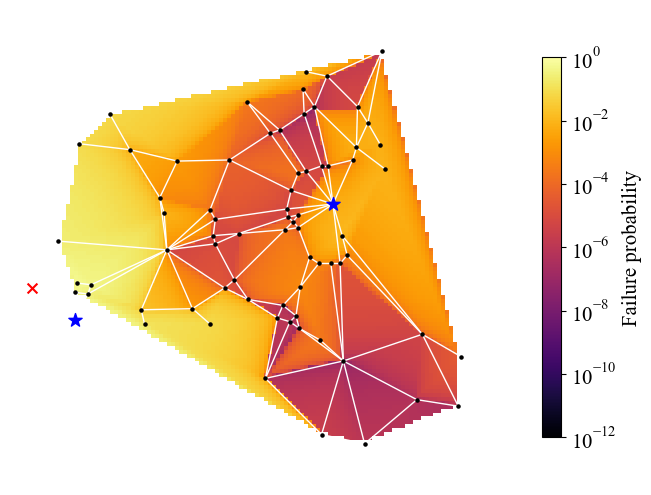

In [159]:
draw_pf_map(node_coords, node_pfs2, arcs, epi_loc2, os_list,cfg.infra['eq']['s2']['Mw'], 'pf_map2.png', is_legend = False, is_cmap = True, margin=[-0.2, 1.0, 0.99, 0.0])

In [22]:
for k, v in node_covs2.items():
    if v > 0.0:
        print(k, v) 
        print(node_pfs[k], node_pfs2[k])

n30 0.0030887462963142963
0.0012633 0.00015371598159584263
n31 0.011807461429211031
0.00034272 9.968927418212017e-06
n32 0.017679203067604413
0.0014056 7.27425674602737e-06
n34 0.019959942258899833
0.0021774 1.0453115661838908e-05
n35 0.037734804614235916
0.0029762 9.973611090594655e-06
n36 0.02622050454393069
0.0022382 3.667691666923313e-06
n43 0.028835077389322117
5.4075e-05 2.763436488301417e-07
n44 0.015849087901305712
6.9113e-05 9.653528273317072e-07
n45 0.027884689549339668
5.029e-05 8.593374544208972e-08
n46 0.029480516123835846
5.5018e-05 1.071097340864537e-06
n47 0.0312742110350821
4.9918e-05 1.3318846026920768e-07
n48 0.027274339998458685
6.4212e-06 2.6279018644743833e-08
n50 0.02245658260680518
8.1016e-07 2.7461043941579603e-07
n51 0.004146603049869237
3.619e-06 5.279525025370936e-07
n52 0.011038606870795145
3.6391e-05 9.027362992225939e-07
n54 0.01848889115536422
0.00063909 2.741465315584136e-07
n58 0.00012649591350017572
0.002298 0.002071208025287775
n59 0.0001865672555572

In [32]:
node_coords.items()

dict_items([('n1', (62.1517, 75.44)), ('n2', (47.6078, 71.464)), ('n3', (51.5838, 70.6269)), ('n4', (46.98, 68.1157)), ('n5', (36.2028, 65.7092)), ('n6', (49.1773, 64.7675)), ('n7', (57.4432, 64.7675)), ('n8', (47.1892, 63.4073)), ('n9', (59.4312, 61.6285)), ('n10', (40.702, 59.6405)), ('n11', (42.4808, 60.2683)), ('n12', (61.8378, 57.4432)), ('n13', (57.234, 56.9201)), ('n14', (56.5015, 54.5135)), ('n15', (62.7795, 52.7348)), ('n16', (50.5375, 53.3626)), ('n17', (51.7931, 53.3626)), ('n18', (46.0383, 52.0023)), ('n19', (47.6078, 52.3162)), ('n20', (32.8546, 54.5135)), ('n21', (44.6781, 48.6541)), ('n22', (52.7348, 46.0383)), ('n23', (43.841, 45.0966)), ('n24', (44.0503, 43.5271)), ('n25', (46.0383, 43.9456)), ('n26', (45.0966, 42.69)), ('n27', (43.5271, 41.1206)), ('n28', (46.0383, 41.5391)), ('n29', (54.5135, 39.9696)), ('n30', (29.0878, 44.8873)), ('n31', (30.1341, 43.1086)), ('n32', (29.7156, 39.9696)), ('n33', (34.6333, 40.3881)), ('n34', (30.1341, 38.4001)), ('n35', (33.7963, 31.

To draw just the graph.

In [161]:
import graphviz as gv

In [198]:
def networkx_to_graphviz(g):
    """Convert `networkx` graph `g` to `graphviz.Digraph`.

    @type g: `networkx.Graph` or `networkx.DiGraph`
    @rtype: `graphviz.Digraph`
    """
    if g.is_directed():
        h = gv.Digraph(engine='neato')
    else:
        h = gv.Graph(engine='neato')

    f_size = '100'
    for u, d in g.nodes(data=True):
        if len(d['label']) == 1:
            label = f" {d['label']} "
        else:
            label = d['label']
        if u in ['n22', 'n66']:
            h.node(str(u), pos = f"{d['pos'][0]},{d['pos'][1]}!", label=label, fontsize=f_size, fillcolor='lightblue', style='filled')
        else:
            h.node(str(u), pos = f"{d['pos'][0]},{d['pos'][1]}!", label=label, fontsize=f_size)
    for u, v, d in g.edges(data=True):
        #h.edge(str(u), str(v), label=d['label'], fontsize=f_size)
        h.edge(str(u), str(v), fontsize=f_size)

    return h

In [199]:
G = nx.Graph()
for e, v in arcs.items():
    G.add_edge(v[0], v[1], label=e)

for n, v in node_coords.items():
    if n != 'epi':
        G.add_node(n, pos=v, label=n[1:])

h = networkx_to_graphviz(G)
outfile = HOME.joinpath('ema_graph')
h.render(outfile, format='png', cleanup=True)


'c:\\Users\\jb622s\\git\\BNS-JT\\BNS_JT\\demos\\pf_map\\ema_graph.png'